In [34]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from itertools import combinations
from statsmodels.stats.multitest import multipletests
from sklearn.isotonic import IsotonicRegression


In [18]:
df = pd.read_csv('data.csv')
df_numeric = df.copy()

def extract_number(x):
    if isinstance(x, str):
        for token in x.split():
            try:
                return float(token)
            except ValueError:
                continue
    return None  
df_numeric.iloc[:, 1:] = df.iloc[:, 1:].applymap(extract_number)

/var/folders/l0/n_657n7d2xdb6sz6mnqb_5zh0000gr/T/ipykernel_37640/2889823559.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_numeric.iloc[:, 1:] = df.iloc[:, 1:].applymap(extract_number)


In [20]:
data = df_numeric.iloc[:, 1:].to_numpy()  # shape: (n, 80)

n_cols = data.shape[1]
cols_to_move = [72, 73, 74, 75]
cols_keep = [i for i in range(n_cols) if i not in cols_to_move]
data_reordered = data[:, cols_keep + cols_to_move]
n = data.shape[0]
data_reshaped = data_reordered.T.reshape(5, 16, n).transpose(1, 0, 2)

In [10]:
data_reshaped.shape

(16, 5, 17)

/var/folders/l0/n_657n7d2xdb6sz6mnqb_5zh0000gr/T/ipykernel_37640/3744759123.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  shades = plt.cm.get_cmap(base_colors[g])(np.linspace(0.5, 0.9, subjects_per_group))


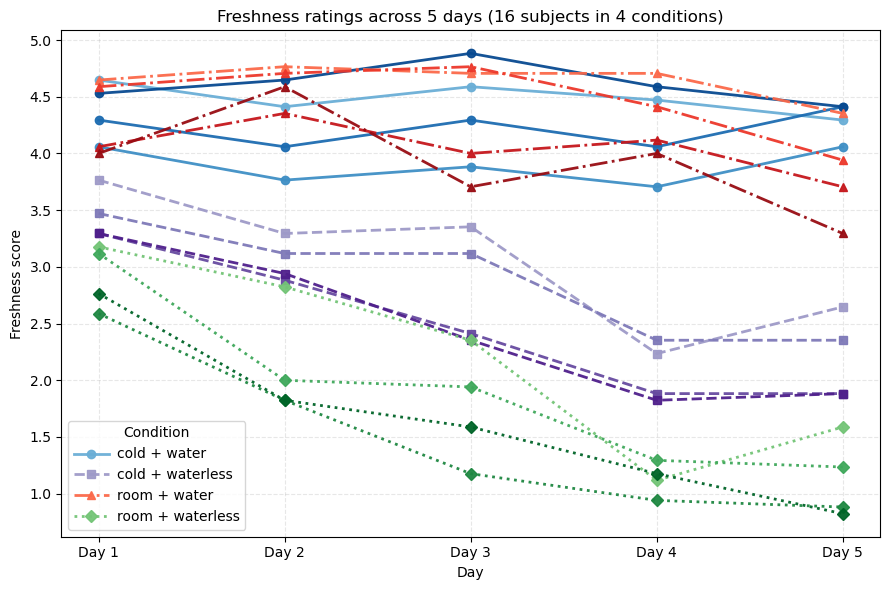

In [22]:


subset = data_reshaped[:, :, :]  
days = np.arange(1, 6)             

n_subjects = subset.shape[0]      
n_repeats = subset.shape[2]
n_groups = 4
subjects_per_group = 4
base_colors = ['Blues', 'Purples', "Reds", "Greens"]

line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D']  # circle, square, triangle, diamond
group_labels = ["cold + water", "cold + waterless", "room + water", "room + waterless"]

plt.figure(figsize=(9, 6))

for g in range(n_groups):
    idx_start = g * subjects_per_group
    idx_end = idx_start + subjects_per_group
    group_data = subset[idx_start:idx_end]
    shades = plt.cm.get_cmap(base_colors[g])(np.linspace(0.5, 0.9, subjects_per_group))

    for i, color in enumerate(shades):
        mean_curve = group_data[i].mean(axis=1)
        plt.plot(
            days, mean_curve,
            color=color,
            lw=2,
            alpha=0.95,
            ls=line_styles[g],
            marker=markers[g],
            markersize=6,
            label=group_labels[g] if i == 0 else None)

plt.xlabel("Day")
plt.ylabel("Freshness score")
plt.title("Freshness ratings across 5 days (16 subjects in 4 conditions)")
plt.xticks(days, [f"Day {d}" for d in days])
plt.grid(True, linestyle="--", alpha=0.3)

handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles)) 
plt.legend(unique.values(), unique.keys(),
           title="Condition",
           loc="best",
           frameon=True,
           handlelength=2.5,
           handletextpad=0.6)

plt.tight_layout()

plt.savefig('non_aggregated.png',dpi=300)
plt.savefig('non_aggregated.pdf',dpi=300)
plt.show()


/var/folders/l0/n_657n7d2xdb6sz6mnqb_5zh0000gr/T/ipykernel_37640/1964038864.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color = plt.cm.get_cmap(base_colors[g])(0.75)
/var/folders/l0/n_657n7d2xdb6sz6mnqb_5zh0000gr/T/ipykernel_37640/1964038864.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color = plt.cm.get_cmap(base_colors[g])(0.75)
/var/folders/l0/n_657n7d2xdb6sz6mnqb_5zh0000gr/T/ipykernel_37640/1964038864.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`

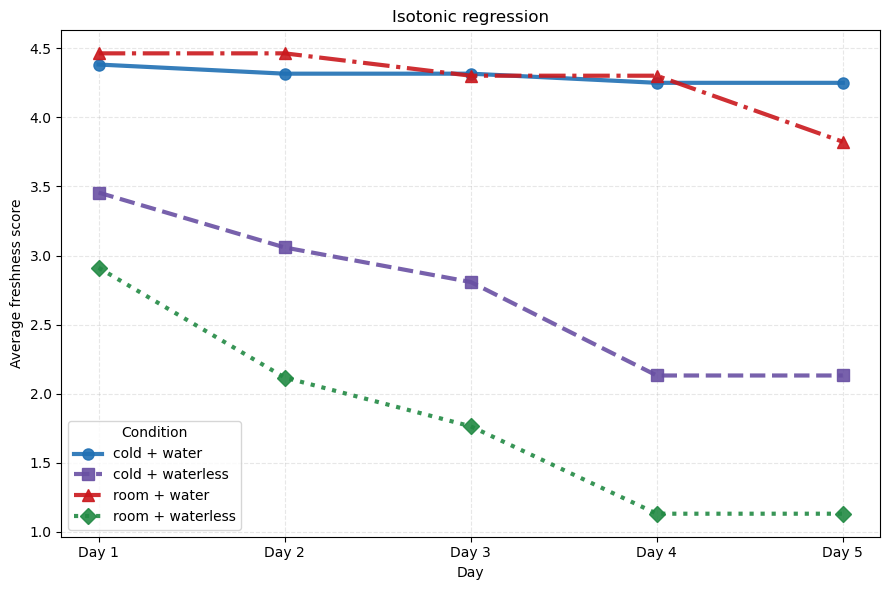

In [36]:
import matplotlib.pyplot as plt
import numpy as np
subset = data_reshaped[:, :, :]  
days = np.arange(1, 6)

n_subjects = subset.shape[0]
n_repeats = subset.shape[2]
n_groups = 4
subjects_per_group = 4

group_labels = ["cold + water", "cold + waterless", "room + water", "room + waterless"]

base_colors = ['Blues', 'Purples', "Reds", "Greens"]
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D']

plt.figure(figsize=(9, 6))

for g in range(n_groups):
    idx_start = g * subjects_per_group
    idx_end = idx_start + subjects_per_group

    group_data = subset[idx_start:idx_end]         
    group_mean = group_data.mean(axis=(0, 2))     

    ir = IsotonicRegression(increasing=False)
    iso_curve = ir.fit_transform(days, group_mean)

    color = plt.cm.get_cmap(base_colors[g])(0.75)

    plt.plot(days, iso_curve,
             color=color,
             lw=3,
             alpha=0.9,
             ls=line_styles[g],
             marker=markers[g],
             markersize=8,
             label=group_labels[g])

plt.xlabel("Day")
plt.ylabel("Average freshness score")
plt.title("Isotonic regression")
plt.xticks(days, [f"Day {d}" for d in days])
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(title="Condition", loc="best", frameon=True)
plt.tight_layout()
plt.savefig('isotonic.pdf',dpi=300)
plt.savefig('isotonic.png',dpi=300)
plt.show()


In [38]:
def nanfree_numeric(arr_like):
    """Return a float64 numpy array with NaNs removed."""
    a = pd.to_numeric(pd.Series(arr_like), errors="coerce").to_numpy(dtype=float)
    return a[np.isfinite(a)]

def cliffs_delta(x, y):
    """Cliff's delta (exact), in [-1, 1]."""
    x = nanfree_numeric(x); y = nanfree_numeric(y)
    if len(x) == 0 or len(y) == 0:
        return np.nan
    gt = (x[:, None] > y[None, :]).sum()
    lt = (x[:, None] < y[None, :]).sum()
    return (gt - lt) / (len(x) * len(y))


In [42]:
import numpy as np
import pandas as pd
from sklearn.isotonic import IsotonicRegression

data_reshaped = np.asarray(data_reshaped, dtype=float)

group_labels = np.array([
    "cold + water",      # flowers 0..3
    "cold + waterless",  # flowers 4..7
    "room + water",      # flowers 8..11
    "room + waterless"   # flowers 12..15
])
days = np.arange(1, data_reshaped.shape[1] + 1)  

def _nanmedian(a, axis):
    return np.nanmedian(a, axis=axis)

def _nanmean(a, axis):
    return np.nanmean(a, axis=axis)

def group_daily_series(data, group_idx, stat="median"):
    start = group_idx * 4
    end = start + 4
    block = data[start:end]  # (4, 5, 17)
    if stat == "median":
        flower_x_day = _nanmedian(block, axis=2)    # (4, 5)
        daily = _nanmedian(flower_x_day, axis=0)    # (5,)
    elif stat == "mean":
        flower_x_day = _nanmean(block, axis=2)
        daily = _nanmean(flower_x_day, axis=0)
    else:
        raise ValueError("stat must be 'median' or 'mean'")
    return daily

def fit_iso_curve(y, decreasing=True):
    ir = IsotonicRegression(increasing=not decreasing)  
    return ir.fit_transform(days, y)

def fit_iso_groups(data, stat="median"):
    curves = np.zeros((4, data.shape[1]))
    for g in range(4):
        y = group_daily_series(data, g, stat=stat)
        curves[g] = fit_iso_curve(y, decreasing=True)
    return curves  # (4, 5)

def hier_bootstrap_iso(data, B=1000, stat="median", seed=0):
    """
    Two-level bootstrap:
      - sample 4 flowers within each group with replacement;
      - for each sampled flower-day, sample 17 raters with replacement;
      - aggregate (median/mean) across raters -> daily value for that flower;
      - aggregate across 4 bootstrapped flowers -> group daily series;
      - run isotonic regression (decreasing) to get a 5-point curve.
    Returns:
      boot_curves: shape (B, 4, 5)
    """
    rng = np.random.default_rng(seed)
    B = int(B)
    boot_curves = np.zeros((B, 4, data.shape[1]))
    for b in range(B):
        for g in range(4):
            block = data[g*4:(g+1)*4]  # (4,5,17)
            # sample 4 flowers with replacement
            f_indices = rng.integers(0, 4, size=4)
            # build bootstrapped flower-by-day matrix
            boot_flower_day = np.zeros((4, data.shape[1]))
            for i, fi in enumerate(f_indices):
                for d in range(data.shape[1]):
                    reps = block[fi, d]  # (17,)
                    reps = reps[np.isfinite(reps)]
                    if reps.size == 0:
                        boot_flower_day[i, d] = np.nan
                    else:
                        rsel = rng.integers(0, reps.size, size=reps.size)
                        samp = reps[rsel]
                        boot_flower_day[i, d] = np.nanmedian(samp) if stat == "median" else np.nanmean(samp)

            daily = np.nanmedian(boot_flower_day, axis=0) if stat == "median" else np.nanmean(boot_flower_day, axis=0)
            boot_curves[b, g] = fit_iso_curve(daily, decreasing=True)
    return boot_curves

def pointwise_bands(boot_curves, q=(2.5, 50, 97.5)):
    lo, med, hi = np.percentile(boot_curves, q, axis=0) 
    return lo, med, hi

def simultaneous_bands(boot_curves, center=None, alpha=0.05):
    """
    Simultaneous bands via the sup-norm pivot:
      center: baseline curve per group (default = bootstrap median)
      For each group g, compute q_g = 1-alpha quantile of sup |boot - center| across days.
      Band = [center - q_g, center + q_g].
    """
    if center is None:
        _, center, _ = pointwise_bands(boot_curves, q=(2.5, 50, 97.5))
    sim_lo = np.zeros_like(center); sim_hi = np.zeros_like(center)
    for g in range(4):
        errs = boot_curves[:, g, :] - center[g]   # (B, 5)
        sup_abs = np.max(np.abs(errs), axis=1)
        qg = np.quantile(sup_abs, 1 - alpha)
        sim_lo[g] = center[g] - qg
        sim_hi[g] = center[g] + qg
    return center, sim_lo, sim_hi

def auc_norm(y):
    return np.trapz(y, days) / 20.0

def pairwise_inference(obs_curves, boot_curves):
    """
    Pairwise differences between the 4 groups:
      - pointwise 95% CI for difference curves
      - global test using sup |diff| (bootstrap p-value)
      - AUC differences with bootstrap two-sided p-value
    """
    pairs = [(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)]
    rows = []
    boot_auc = np.trapz(boot_curves, days, axis=2) / 20.0  # (B,4)
    obs_auc = np.array([auc_norm(obs_curves[g]) for g in range(4)])
    for a, b in pairs:
        diff_obs = obs_curves[a] - obs_curves[b]                # (5,)
        diff_boot = boot_curves[:, a, :] - boot_curves[:, b, :] # (B,5)

        diff_lo = np.percentile(diff_boot, 2.5, axis=0)
        diff_hi = np.percentile(diff_boot, 97.5, axis=0)

        sup_obs = np.max(np.abs(diff_obs))
        sup_boot = np.max(np.abs(diff_boot), axis=1)
        p_sup = float(np.mean(sup_boot >= sup_obs))


        auc_obs = float(obs_auc[a] - obs_auc[b])
        auc_boot = boot_auc[:, a] - boot_auc[:, b]
        p_auc = float(2 * min(np.mean(auc_boot >= 0), np.mean(auc_boot <= 0)))

        rows.append({
            "pair": f"{group_labels[a]}  -  {group_labels[b]}",
            "pointwise_CI_low": diff_lo,
            "pointwise_CI_high": diff_hi,
            "global_supnorm_p": p_sup,
            "AUC_diff_obs": auc_obs,
            "AUC_p_boot": p_auc
        })
    return rows
obs_iso = fit_iso_groups(data_reshaped, stat="median")   # (4, 5)
boot_iso = hier_bootstrap_iso(data_reshaped, B=1000, stat="median", seed=2025) 
pt_lo, pt_med, pt_hi = pointwise_bands(boot_iso)                # (4,5) each
ctr, sim_lo, sim_hi  = simultaneous_bands(boot_iso, center=pt_med, alpha=0.05)
pairwise_results = pairwise_inference(obs_iso, boot_iso)
iso_results = {
    "group_labels": group_labels,
    "obs_iso_curves": pd.DataFrame(obs_iso, index=group_labels, columns=[f"Day {d}" for d in days]),
    "pointwise_lo":   pd.DataFrame(pt_lo, index=group_labels, columns=[f"Day {d}" for d in days]),
    "pointwise_med":  pd.DataFrame(pt_med, index=group_labels, columns=[f"Day {d}" for d in days]),
    "pointwise_hi":   pd.DataFrame(pt_hi, index=group_labels, columns=[f"Day {d}" for d in days]),
    "simul_center":   pd.DataFrame(ctr, index=group_labels, columns=[f"Day {d}" for d in days]),
    "simul_lo":       pd.DataFrame(sim_lo, index=group_labels, columns=[f"Day {d}" for d in days]),
    "simul_hi":       pd.DataFrame(sim_hi, index=group_labels, columns=[f"Day {d}" for d in days]),
    "pairwise":       pairwise_results
}


In [44]:
summary_df = pd.concat([
    iso_results["pointwise_med"].assign(type="median"),
    iso_results["pointwise_lo"].assign(type="lo"),
    iso_results["pointwise_hi"].assign(type="hi")
])
print(summary_df)

                  Day 1  Day 2  Day 3    Day 4     Day 5    type
cold + water       4.50   4.50   4.50  4.50000  4.000000  median
cold + waterless   3.50   3.00   3.00  2.00000  2.000000  median
room + water       4.75   4.75   4.50  4.25000  4.000000  median
room + waterless   3.00   2.00   1.50  1.00000  1.000000  median
cold + water       4.00   4.00   4.00  3.83125  3.831250      lo
cold + waterless   3.00   3.00   2.00  1.75000  1.500000      lo
room + water       4.00   4.00   4.00  4.00000  3.833333      lo
room + waterless   2.50   2.00   1.00  0.75000  0.000000      lo
cold + water       5.00   5.00   5.00  5.00000  4.801875      hi
cold + waterless   4.00   3.50   3.25  2.75625  2.750000      hi
room + water       5.00   5.00   5.00  5.00000  5.000000      hi
room + waterless   3.50   3.00   2.00  1.50000  1.250000      hi


/var/folders/l0/n_657n7d2xdb6sz6mnqb_5zh0000gr/T/ipykernel_37640/2805421629.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = [plt.cm.get_cmap(cm)(0.75) for cm in base_maps]


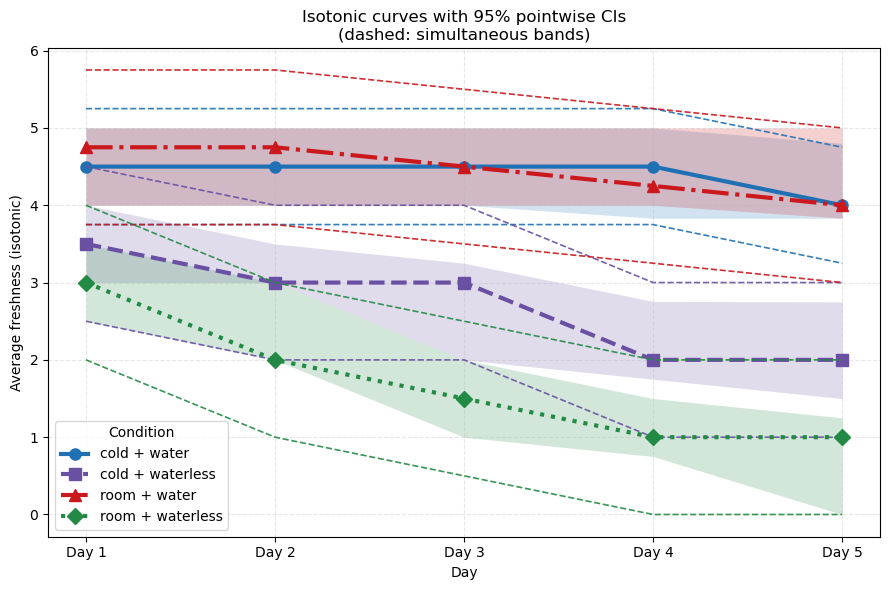

In [48]:


med = iso_results["pointwise_med"]   # (4 x 5) DataFrame
lo  = iso_results["pointwise_lo"]    # (4 x 5) DataFrame
hi  = iso_results["pointwise_hi"]    # (4 x 5) DataFrame
sim_lo = iso_results.get("simul_lo", None)  
sim_hi = iso_results.get("simul_hi", None) 

# Group labels & days
if "group_labels" in iso_results:
    group_labels = list(iso_results["group_labels"])
else:
    group_labels = list(med.index)

days = np.arange(1, med.shape[1] + 1)

base_maps = ['Blues', 'Purples', 'Reds', 'Greens']
colors = [plt.cm.get_cmap(cm)(0.75) for cm in base_maps]

line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D']  # circle, square, triangle, diamond

plt.figure(figsize=(9, 6))

for g, label in enumerate(group_labels):
    y  = med.iloc[g].values
    lo_g = lo.iloc[g].values
    hi_g = hi.iloc[g].values

    plt.fill_between(days, lo_g, hi_g, color=colors[g], alpha=0.20, linewidth=0)

    # Median curve
    plt.plot(days, y,
             color=colors[g],
             lw=3,
             ls=line_styles[g],
             marker=markers[g],
             markersize=8,
             label=label)

    if (sim_lo is not None) and (sim_hi is not None):
        slo = sim_lo.iloc[g].values
        shi = sim_hi.iloc[g].values
        plt.plot(days, slo, color=colors[g], lw=1.2, ls='--', alpha=0.9)
        plt.plot(days, shi, color=colors[g], lw=1.2, ls='--', alpha=0.9)

plt.xlabel("Day")
plt.ylabel("Average freshness (isotonic)")
plt.title("Isotonic curves with 95% pointwise CIs\n(dashed: simultaneous bands)")
plt.xticks(days, [f"Day {d}" for d in days])
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(title="Condition", loc="best", frameon=True)

plt.tight_layout()

plt.savefig('isotonic.pdf',dpi=300)
plt.savefig('isotonic.png',dpi=300)
plt.show()

In [50]:

obs_iso  = iso_results["obs_iso_curves"].to_numpy()   # (4,5)
boot_iso = boot_iso                                  # (B,4,5)
group_labels = ["cold + water", "cold + waterless", "room + water", "room + waterless"]
days = np.arange(1,6)

obs_temp = obs_iso[[2,3]].mean() - obs_iso[[0,1]].mean()       
obs_water = obs_iso[[1,3]].mean() - obs_iso[[0,2]].mean()      
obs_inter = ((obs_iso[0]-obs_iso[1]) - (obs_iso[2]-obs_iso[3])).mean()  

boot_temp = boot_iso[:,[2,3],:].mean(axis=(1,2)) - boot_iso[:,[0,1],:].mean(axis=(1,2))
boot_water = boot_iso[:,[1,3],:].mean(axis=(1,2)) - boot_iso[:,[0,2],:].mean(axis=(1,2))
boot_inter = ((boot_iso[:,0,:] - boot_iso[:,1,:]) -
              (boot_iso[:,2,:] - boot_iso[:,3,:])).mean(axis=1)

p_temp = 2 * min(np.mean(boot_temp >= 0), np.mean(boot_temp <= 0))
p_water = 2 * min(np.mean(boot_water >= 0), np.mean(boot_water <= 0))
p_inter = 2 * min(np.mean(boot_inter >= 0), np.mean(boot_inter <= 0))

ci_temp = np.percentile(boot_temp, [2.5,97.5])
ci_water = np.percentile(boot_water, [2.5,97.5])
ci_inter = np.percentile(boot_inter, [2.5,97.5])

results = pd.DataFrame({
    "Effect": ["Temperature (room-cold)", "Water (waterless-water)", "Interaction"],
    "Estimate": [obs_temp, obs_water, obs_inter],
    "CI_low": [ci_temp[0], ci_water[0], ci_inter[0]],
    "CI_high": [ci_temp[1], ci_water[1], ci_inter[1]],
    "p_boot": [p_temp, p_water, p_inter]
})
print(results.round(3))



                    Effect  Estimate  CI_low  CI_high  p_boot
0  Temperature (room-cold)     -0.35   -0.85     0.00   0.080
1  Water (waterless-water)     -2.25   -2.65    -1.75   0.000
2              Interaction     -0.90   -1.90    -0.10   0.038
